<a href="https://colab.research.google.com/github/mivantec/Ivantechenko_BIX_F21/blob/main/MI_Homework4_reinforcment_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcment Learning Homework

## Section A - Notebook Setup [5 pts]

To help prepare you for the class project, we are going to ask you to set up your notebook slightly differently this time: Rather than installing explorationlib from one of its existing git repositories (such as `parenthetical-e` or `clappm`), install it from a git repository that you own.  Fork the code!

In [6]:
!pip install --upgrade git+https://github.com/mivantec/explorationlib
!pip install --upgrade git+https://github.com/mivantec/gym-maze.git

  Cloning https://github.com/mivantec/explorationlib to /tmp/pip-req-build-a1tu75ef
  Running command git clone -q https://github.com/mivantec/explorationlib /tmp/pip-req-build-a1tu75ef
  Cloning https://github.com/mivantec/gym-maze.git to /tmp/pip-req-build-05xsav52
  Running command git clone -q https://github.com/mivantec/gym-maze.git /tmp/pip-req-build-05xsav52
     |████████████████████████████████| 18.3 MB 1.2 MB/s 
  Created wheel for gym-maze: filename=gym_maze-0.4-py3-none-any.whl size=14241 sha256=c63972c11f1db80c22e322ac33d2cde88eed272902b72a0d33f69d6d6e553428
  Stored in directory: /tmp/pip-ephem-wheel-cache-b1zuugdq/wheels/26/4c/55/3ce749ac159c151217e79b011a2159672be4ccf12cabcaf5d2
Successfully built gym-maze


## Section B - Understanding the code structure [5 pts]

*pop quiz!*

In the lab, we went over the python classes for `RandomActor`, `SequentialActor`, and `EpsilonActor`.  We did not however show the code for `BoundedRandomActor` or `BoundedSequentialActor`.  Please post the class definitions for those agents below, so that we know that you know where to find them.

In [ ]:
# BoundedRandomActor
class BoundedRandomActor(BanditAgent):
    def __init__(self, num_actions, bound=100):
        super().__init__()
        self.num_actions = num_actions
        self.bound = int(bound)
        self.actions = list(range(self.num_actions))

    def __call__(self, values):
        return self.forward(values)

    def forward(self, values):
        """Values are a dummy var. Pick at random"""
        self.action_count += 1
        if self.action_count < self.bound:
            action = self.np_random.choice(self.actions)
        else:
            action = np.argmax(values)

        return action

    def reset(self):
        self.action_count = 0

In [ ]:
# BoundedSequentialActor
class BoundedSequentialActor(BanditAgent):
    """Choose actions in sequence; ignore value"""
    def __init__(self, num_actions, bound=100, initial_action=0):
        super().__init__()

        self.num_actions = int(num_actions)
        self.initial_action = int(initial_action)
        self.action_count = self.initial_action
        self.bound = int(bound)

    def __call__(self, values):
        return self.forward(values)

    def forward(self, values):
        self.action_count += 1

        if self.action_count < self.bound:
            action = self.action_count % self.num_actions
        else:
            action = np.argmax(values)

        return action

    def reset(self):
        self.action_count = self.initial_action

## Section C - Understanding Entropy

### Question [10 pts]

As discussed in lab, both the Random and Sequential explorers produce max-entropy behavior asymptotically.  If we ran 100 bandit experiments (similar to those in Section 1.3 of Lab), how often do you expect the measured entropy of the Random agent to *exceed* the entropy of the Sequential agent?  Please justify your answer.

I would expect the measured entropy of the Random agent to exceed the entropy less often than the sequential agent. While on some turns the random agent might exceed the measured entropy of the sequential agent, on others it is just as likely that it will not exceed or have a lower measured entropy since it is choosing randomly. On the other hand, since the sequential agent is choosing sequentially, it will continue to increase in entropy. This is supported by the mean entropy seen in the title of the action probability histograms for each agent in Section 1.3 of Lab, (I reran w/ 100 bandit experiments instead of 1 for the lab) with random agent having mean entropy of 1.24 and sequential agent 1.37 (so on avg, sequential has higher entropy).

### Question [5 pts]

If you had to pick one (either Random or Sequential) as your personal bandit exploration strategy, which would you choose and why?

I would choose the Sequential agent as my personal bandit strategy over the Random agent. Since the Sequential agent is choosing sequentially, I know it will choose the optimal arm some amount of times. However, with the Random agent, I don't have that guarantee. It's entirely possible that it will randomly choose the two non-optimal arms over and over and never choose the optimal arm. While the opposite is also theoretically true (eg choose optimal arm all the time and never the others), I think it's safer to go with the Sequential agent.

### Running sims of the $\epsilon$-greedy agent [5 pts]

Consider the $\epsilon$-greedy agent we explored in Section 1.4 of lab.  There, we only looked at three values for epsilon (0.05, 0.5, 0.95). Pick at least 3 more episilon values, add them to that list, and rerun the 40 experiments of 400 steps each.

In [7]:
# import basic modules
import shutil
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import explorationlib
import explorationlib

# import the type of environment we will be using
from explorationlib.local_gym import BanditUniform4

# import the components to build our agents
from explorationlib.agent import BanditActorCritic
from explorationlib.agent import Critic
from explorationlib.agent import EpsilonActor
from explorationlib.agent import RandomActor
from explorationlib.agent import SequentialActor
from explorationlib.agent import BoundedRandomActor
from explorationlib.agent import BoundedSequentialActor

# import the experimental framework
from explorationlib.run import experiment

# import some scoring functions
from explorationlib.score import total_reward
from explorationlib.score import action_entropy

# import some utility functions
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

# import some plotting functions
from explorationlib.plot import plot_bandit
from explorationlib.plot import plot_bandit_actions
from explorationlib.plot import plot_bandit_critic
from explorationlib.plot import plot_bandit_hist

pygame 2.1.0 (SDL 2.0.16, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [9]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

In [10]:
# Shared env params
seed = 503

# Create env
env = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.35)
env.seed(seed)

[503]

In [34]:
ran = BanditActorCritic(
    RandomActor(num_actions=env.num_arms),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
seq = BanditActorCritic(
    SequentialActor(num_actions=env.num_arms),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
epy = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.1),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)

# organize them
agents = [ran, seq, epy]
names = ["random", "sequential", "ep-greedy"]
colors = ["blue", "green", "purple"]

num_steps = 4 * 100
epsilons = [0.05, 0.10, 0.25, 0.5, 0.75, 0.95]

names = [str(epsilon) for epsilon in epsilons]
colors = ["purple", "mediumpurple", "orchid", "mediumorchid", "violet", "mediumvioletred"]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

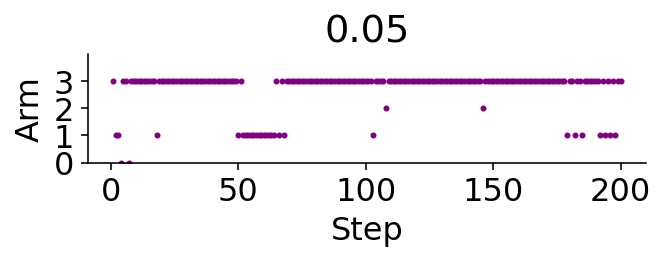

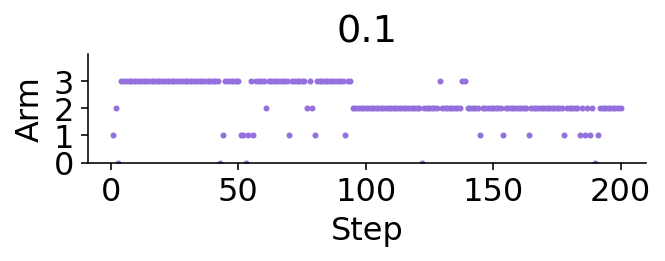

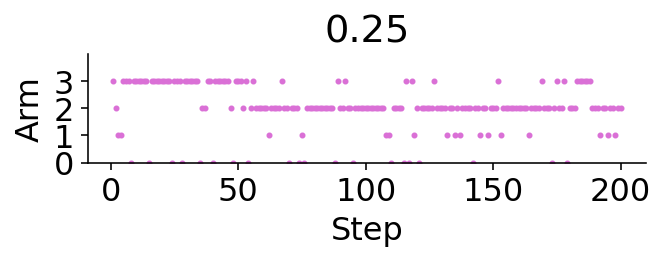

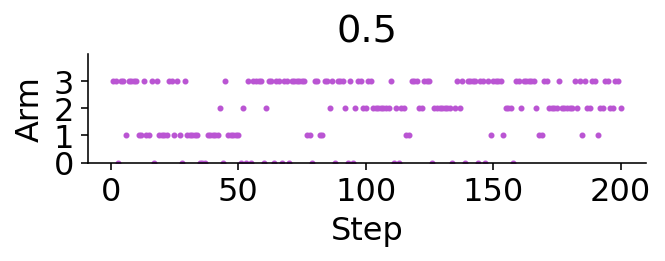

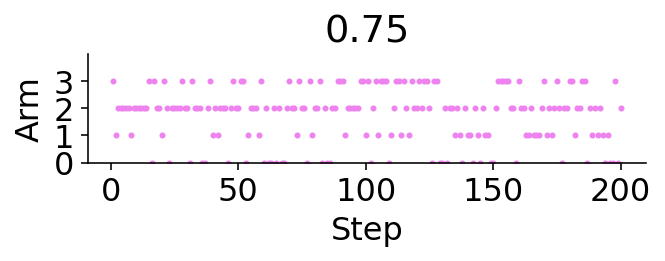

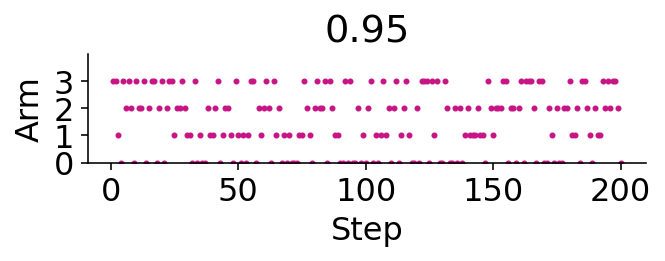

In [35]:
# !
results = []
for i, (name, epsilon) in enumerate(zip(names, epsilons)):
    agent = BanditActorCritic(
        EpsilonActor(num_actions=env.num_arms, epsilon=epsilon),
        Critic(num_inputs=env.num_arms, default_value=0.0)
    )
    log = experiment(
        f"ep_{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=100,
        dump=False,
        split_state=False,
    )
    results.append(log)

num_experiment = 40
for name, res, color in zip(names, results, colors):
    plot_bandit_actions(
        select_exp(res, num_experiment), 
        max_steps=200,
        s=4,
        title=name, 
        color=color,
        figsize=(5, 1)
        )

### Plotting the results [10 pts]

Plot the mean rewards and the mean entropy values for the agents.  (The two bar charts in Section 1.4).

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

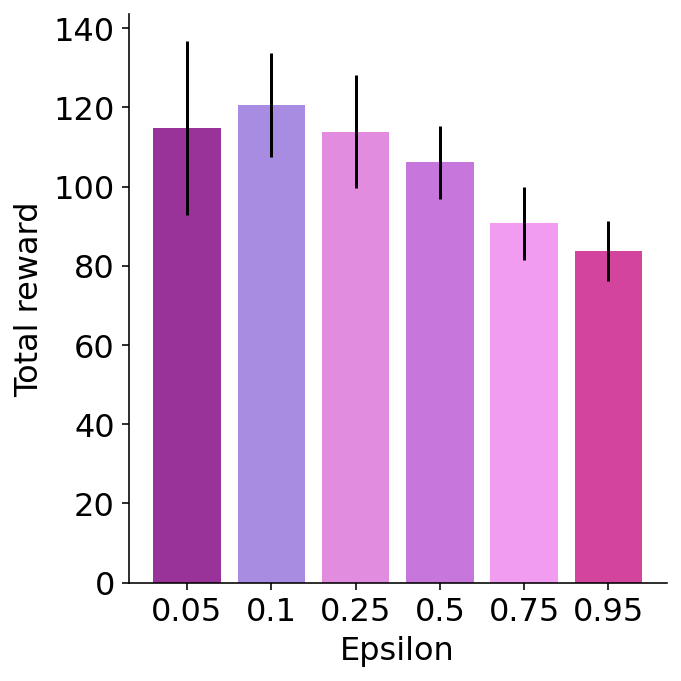

In [39]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 5))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Epsilon")
plt.tight_layout()
sns.despine()

action_entropy:   0%|          | 0/100 [00:00<?, ?it/s]

action_entropy:   0%|          | 0/100 [00:00<?, ?it/s]

action_entropy:   0%|          | 0/100 [00:00<?, ?it/s]

action_entropy:   0%|          | 0/100 [00:00<?, ?it/s]

action_entropy:   0%|          | 0/100 [00:00<?, ?it/s]

action_entropy:   0%|          | 0/100 [00:00<?, ?it/s]

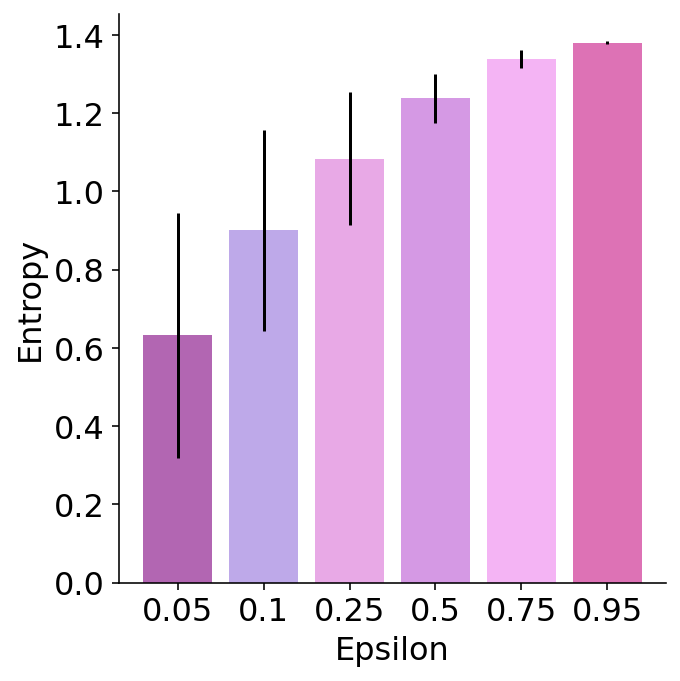

In [40]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = action_entropy(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 5))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Entropy")
plt.xlabel("Epsilon")
plt.tight_layout()
sns.despine()

### Question [5 pts] 

In your own words, explain how $\epsilon$ seems to relate to _total reward_ and _action entropy_. As $\epsilon$ grows, what happens?

As 𝜖 increases, total reward seems to decrease for the most part (transition between 0.05 and 0.1 is an exception) and action entropy seems to increase.

### Question [5 pts]

Let's ask this again from another direction. When looking at the performance of the $\epsilon$-greedy agents, what relationship do you see between _total reward_ and _action entropy_?  To answer, focus on the the bar plots of entropy and reward.

Can you explain this correlation in terms of the explore-exploit dilemma?

Since both are related to 𝜖 in an opposite direction (e.g., one increases w/ 𝜖 while other decreases), total reward and action entropy seem to have an inverse relationship. This correlation makes sense -- exploiting (more likely to happen when 𝜖 is smaller) is tied to higher total reward because you are more likely to choose an action you know will result in reward, decreases as likelihood of exploring increases. Exploiting tied to less action entropy because you're probably choosing the same action, rather than finding new actions to choose. 

### Question [5 pts]

Does there seem to be any relationship between epsilon and the *standard deviation* of rewards (the error bars on the bar chart)?  Why might we expect such a relationship to exist? 

Looks like higher 𝜖 tied to smaller SD of rewards (error bars get narrower as 𝜖 increases). Might expect such a relationship to exist because the amount of reward gained on avg for exploiting vs. exploring is likely very different. Exploiting will more than likely result in reward gained when done vs. exploring which may or may not result in reward gained. So when 𝜖 is low (exploiting pretty much all the time) but not zero (sometimes exploring), the variability in reward gained on any given run is large because exploring and not getting reward would drop total reward down drastically. As 𝜖 increases and likelihood of exploring increases, chance of exploring and not getting reward won't affect/skew total reward as much since exploring is becoming the dominant action, so variability decreases. 

## Section D - Tuning epsilon [15 pts]

In the lab, we did not attempt to tune the value of epsilon.  Now, it is your turn to do so.

Try to estimate the optimal value of epsilon (for this very particular bandit task). We recognize that the results will be quite noisy, and that it will be essentially impossible to tell which precise value of $\epsilon$ is truly the best. Give it a good shot but don't overanalyze it.

The coding is up to you, but we ask that you clearly show your tuning process: Put each batch of simulations you run into a separate code cell, so that we can see all of the plots you make. This way, you are showing us your work.

RESPONSE: I was tuning 𝜖 based on total reward. I think the optimal value of 𝜖 is somewhere between 0.1 - 0.35. Below that, the variability is too high and total reward isn't always the highest (prob bc of explore dragging it down). Above that, total reward also seems to start decreasing as explore starts to dominate as an action. Within that range, total reward seems to be relatively consistently high and variability isn't too high as well. I'll choose a value in the middle (0.2) for the next part of the lab.

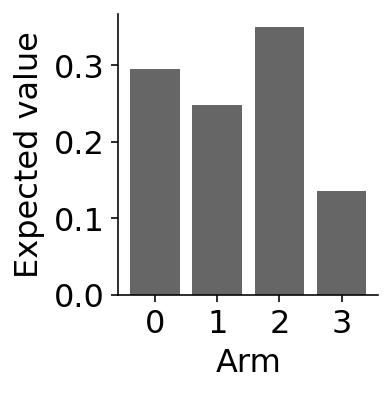

In [41]:
# DO NOT CHANGE:

# Shared env params
num_experiments = 100
seed = 593  

# Create env
env = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.35)
env.seed(seed)

# Plot env
plot_bandit(env, alpha=0.6)

num_steps = 4 * 100
num_experiments = 250

In [48]:
epy = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.1),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)

# organize them
agents = [ran, seq, epy]
names = ["random", "sequential", "ep-greedy"]
colors = ["blue", "green", "purple"]

num_steps = 4 * 100
epsilons = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

names = [str(epsilon) for epsilon in epsilons]
colors = ["purple", "mediumpurple", "orchid", "mediumorchid", "violet", "mediumvioletred"]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

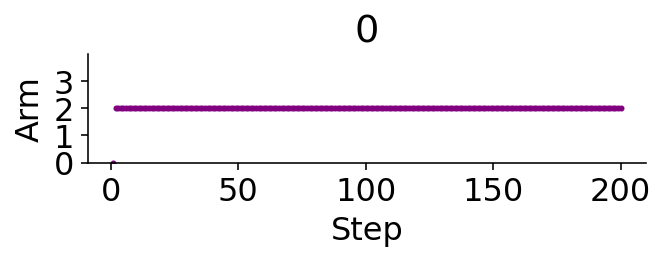

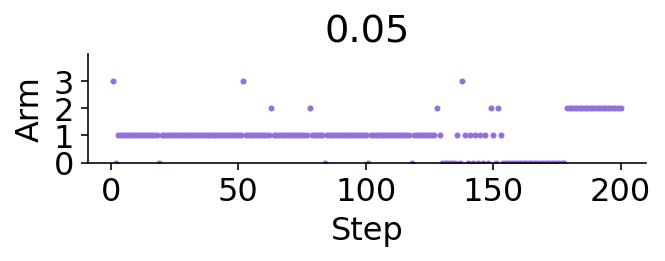

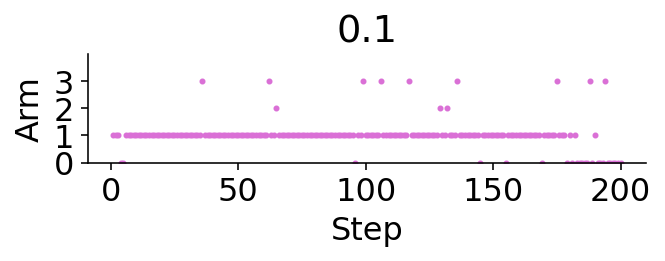

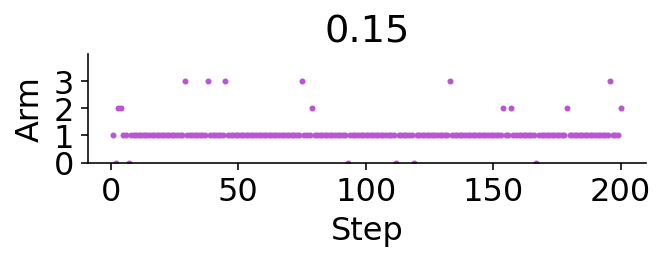

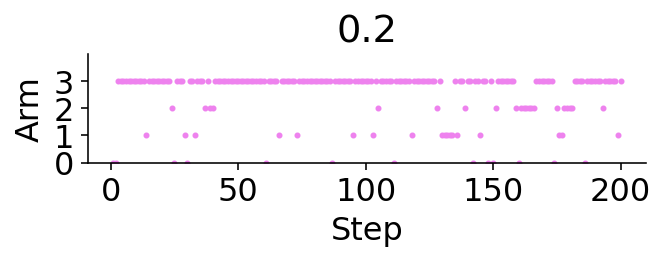

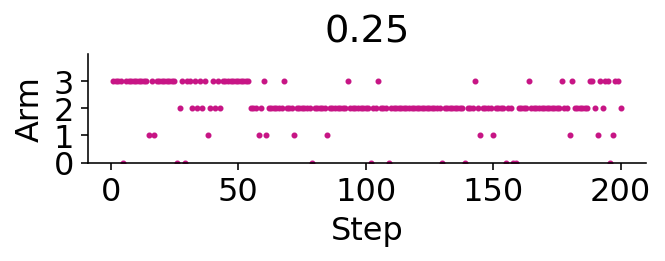

In [49]:
# !
results = []
for i, (name, epsilon) in enumerate(zip(names, epsilons)):
    agent = BanditActorCritic(
        EpsilonActor(num_actions=env.num_arms, epsilon=epsilon),
        Critic(num_inputs=env.num_arms, default_value=0.0)
    )
    log = experiment(
        f"ep_{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=100,
        dump=False,
        split_state=False,
    )
    results.append(log)

num_experiment = 40
for name, res, color in zip(names, results, colors):
    plot_bandit_actions(
        select_exp(res, num_experiment), 
        max_steps=200,
        s=4,
        title=name, 
        color=color,
        figsize=(5, 1)
        )

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

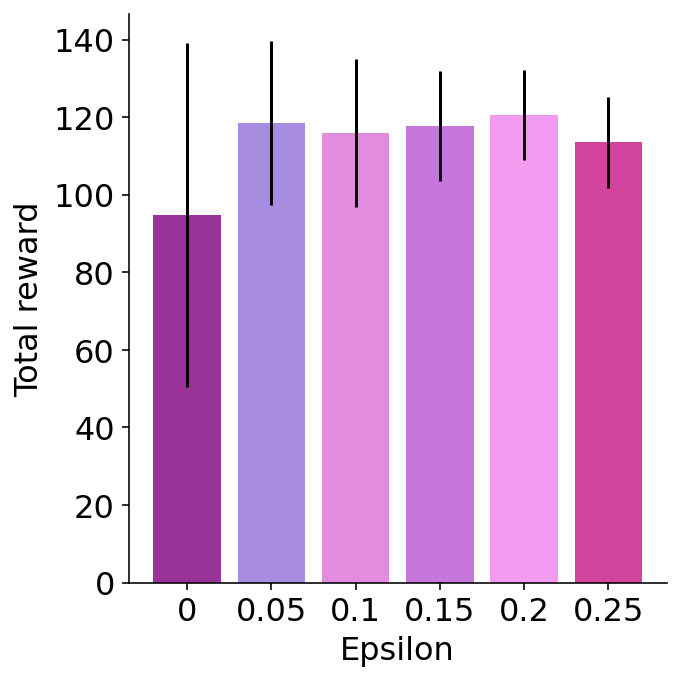

In [50]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 5))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Epsilon")
plt.tight_layout()
sns.despine()

In [52]:
epy = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.1),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)

# organize them
agents = [ran, seq, epy]
names = ["random", "sequential", "ep-greedy"]
colors = ["blue", "green", "purple"]

num_steps = 4 * 100
epsilons = [0.1, 0.15, 0.20, 0.25, 0.3, 0.35]

names = [str(epsilon) for epsilon in epsilons]
colors = ["purple", "mediumpurple", "orchid", "mediumorchid", "violet", "mediumvioletred"]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

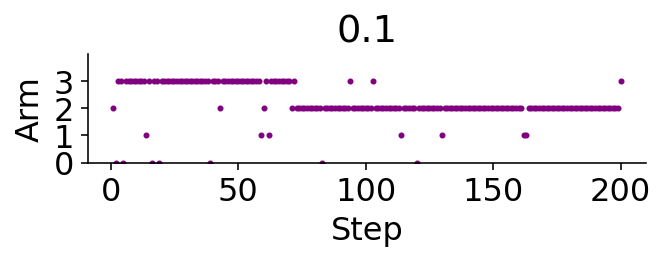

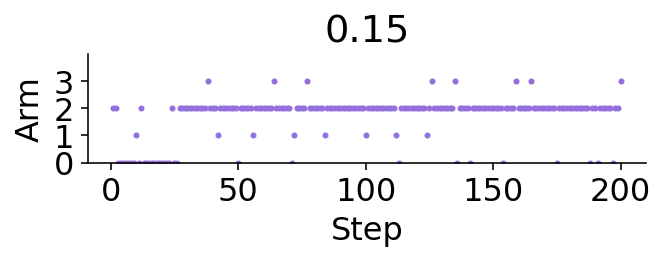

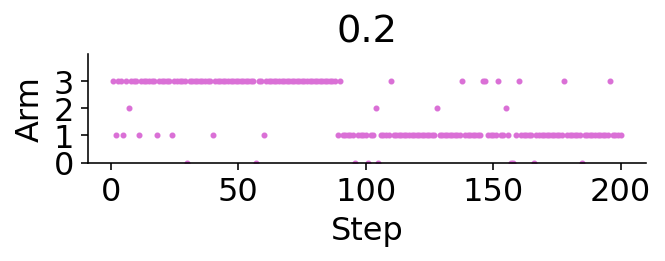

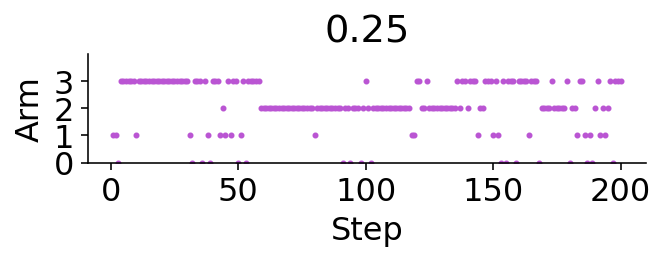

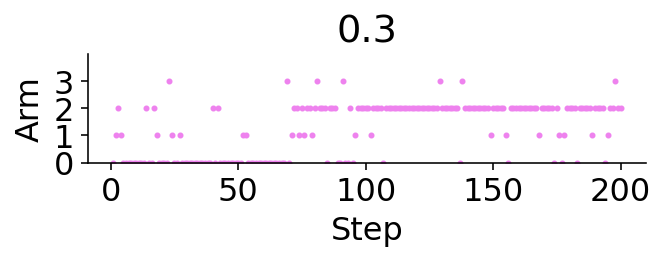

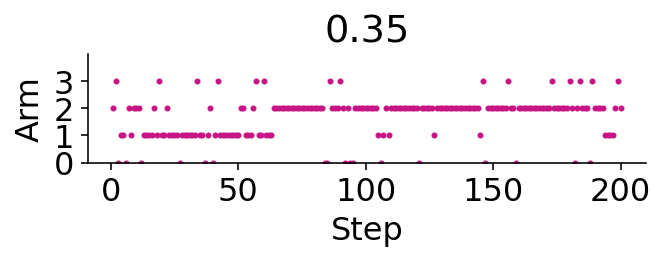

In [53]:
# !
results = []
for i, (name, epsilon) in enumerate(zip(names, epsilons)):
    agent = BanditActorCritic(
        EpsilonActor(num_actions=env.num_arms, epsilon=epsilon),
        Critic(num_inputs=env.num_arms, default_value=0.0)
    )
    log = experiment(
        f"ep_{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=100,
        dump=False,
        split_state=False,
    )
    results.append(log)

num_experiment = 40
for name, res, color in zip(names, results, colors):
    plot_bandit_actions(
        select_exp(res, num_experiment), 
        max_steps=200,
        s=4,
        title=name, 
        color=color,
        figsize=(5, 1)
        )

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

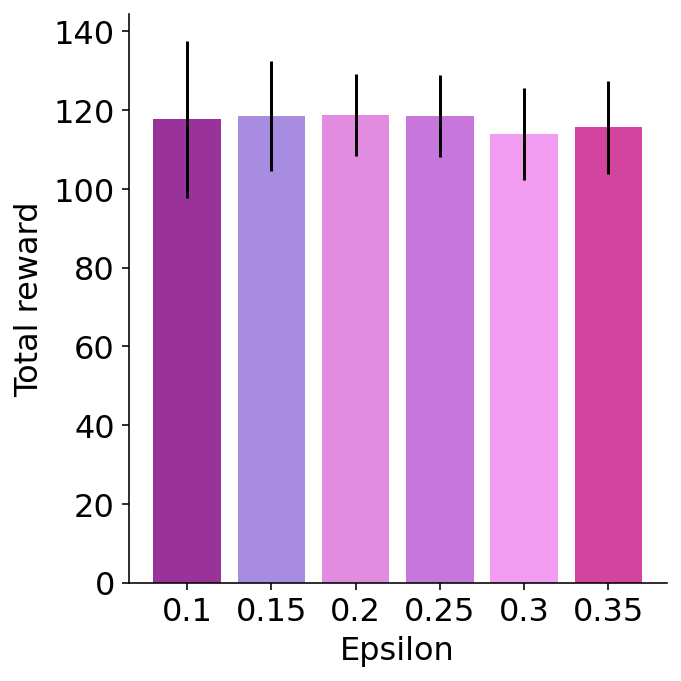

In [54]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 5))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Epsilon")
plt.tight_layout()
sns.despine()

In [57]:
epy = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.1),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)

# organize them
agents = [ran, seq, epy]
names = ["random", "sequential", "ep-greedy"]
colors = ["blue", "green", "purple"]

num_steps = 4 * 100
epsilons = [0.35, 0.40, 0.50, 0.55, 0.65, 0.7]

names = [str(epsilon) for epsilon in epsilons]
colors = ["purple", "mediumpurple", "orchid", "mediumorchid", "violet", "mediumvioletred"]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

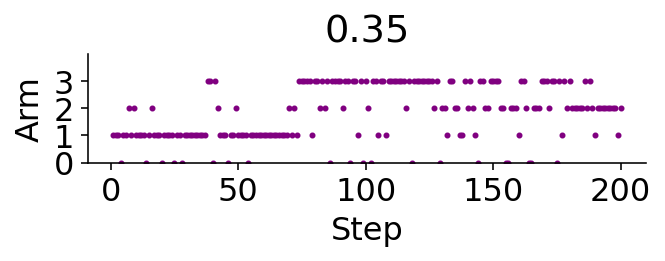

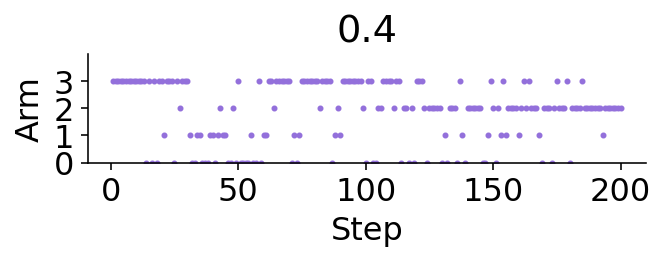

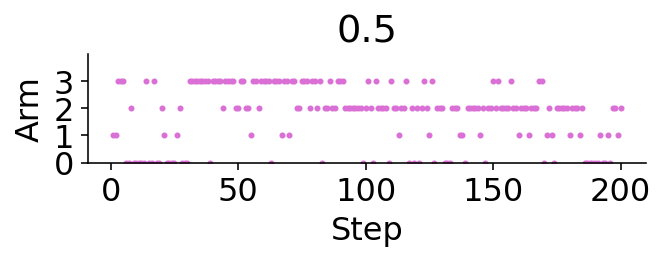

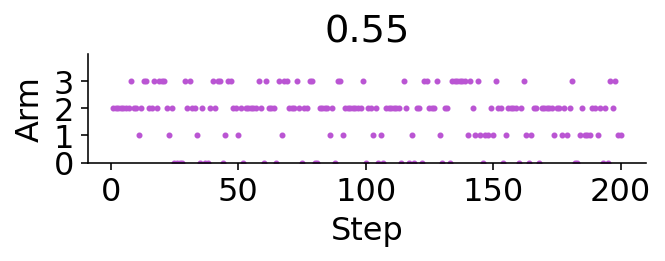

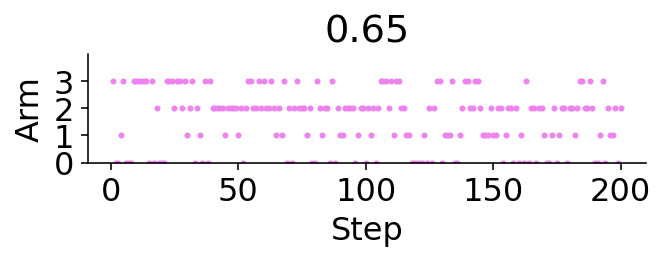

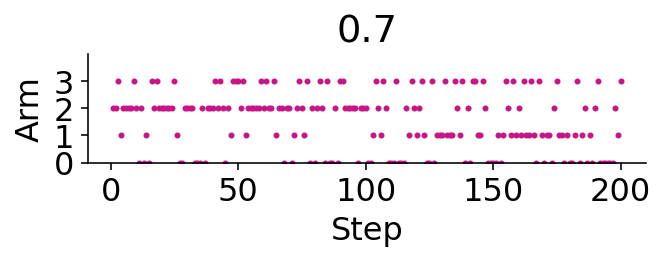

In [58]:
# !
results = []
for i, (name, epsilon) in enumerate(zip(names, epsilons)):
    agent = BanditActorCritic(
        EpsilonActor(num_actions=env.num_arms, epsilon=epsilon),
        Critic(num_inputs=env.num_arms, default_value=0.0)
    )
    log = experiment(
        f"ep_{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=100,
        dump=False,
        split_state=False,
    )
    results.append(log)

num_experiment = 40
for name, res, color in zip(names, results, colors):
    plot_bandit_actions(
        select_exp(res, num_experiment), 
        max_steps=200,
        s=4,
        title=name, 
        color=color,
        figsize=(5, 1)
        )

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

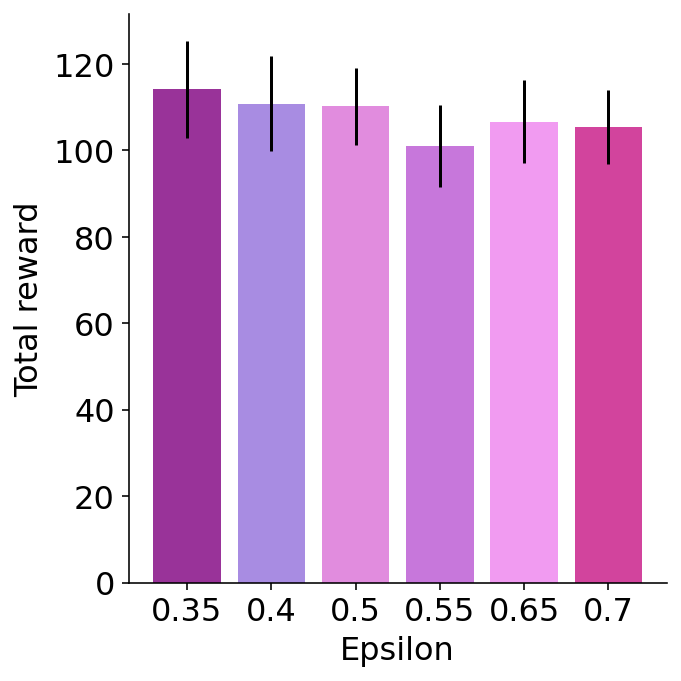

In [59]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 5))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Epsilon")
plt.tight_layout()
sns.despine()

## Section E - Comparing the tuned agents

### Coding [10 pts]

Rerun the code from Section 2.3 of the lab, to compare the tuned $\epsilon$-greedy agent to the tuned bounded random and bounded sequential agents. Now, since we have tuned all three agents, the playing field is a bit more level.

Plot the average rewards of the three agents.

In [60]:
bound = 75  # use 75 as the "tuned" bound
epsilon = 0.2

In [63]:
bounded_ran = BanditActorCritic(
    BoundedRandomActor(num_actions=env.num_arms, bound=bound),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
bounded_seq = BanditActorCritic(
    BoundedSequentialActor(num_actions=env.num_arms, bound=bound),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
epy = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=epsilon),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)

# organize them
agents = [bounded_ran, bounded_seq, epy]
names = ["b-ran", "b-seq", "ep-greedy"]
colors = ["blue", "green", "purple"]

In [64]:
num_steps = 400  # Three rounds per arm, about that anyway
num_experiments = 250

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

b-ran:   0%|          | 0/250 [00:00<?, ?it/s]

b-seq:   0%|          | 0/250 [00:00<?, ?it/s]

ep-greedy:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

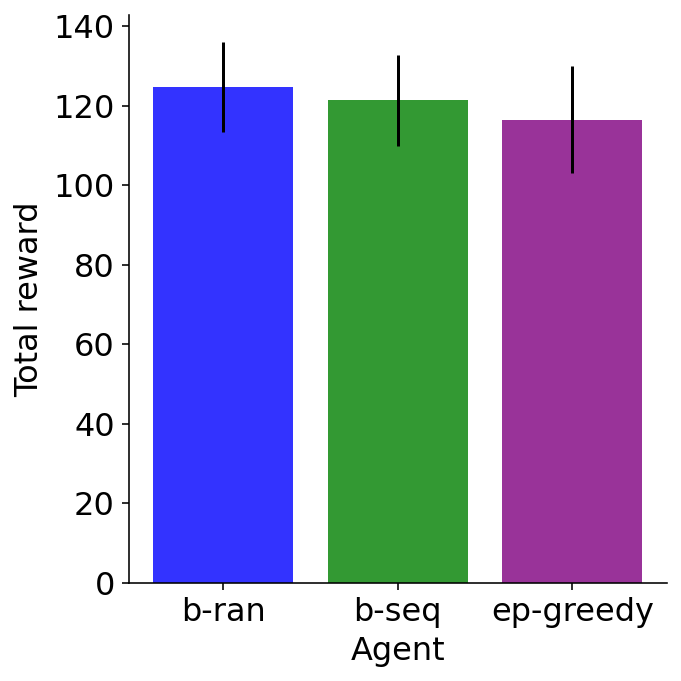

In [65]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 5))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Agent")
plt.tight_layout()
sns.despine()

### Question [5 pts]

So, given these results, what's a better way to maximize total reward in this (reporting) task? Is it BoundedRandomActor? Or, BoundedSeqentialActor? Or is it _EpsilonActor_?

Based on the above results, BoundedRandomActor has the highest total reward (though all three agents had pretty much the same total reward) and a lowish variability compared to the other two agents. So I would say BoundedRandomActor is the better way to maximize total reward in this task.

## Section F - Changing the number of steps

Throughout the tuning process, we have assumed that each bandit experiment lasted 400 steps. As a result, our agents are essentially designed to perform well for that particular setup.  In this section, we are going to ask you to run simulation batches with different values of `num_steps`, to see if the results of the previous section still hold true in a more general situation.

### Coding task: Re-running Section E with num_steps = 25, 100, and 1600 [10 pts]

Between section E and section F combined, you should end up with four total plots, showing the bar chart of mean rewards for step counts 25, 100, 400, and 1600.

In [66]:
bound = 75  # use 75 as the "tuned" bound
epsilon = 0.2

In [67]:
bounded_ran = BanditActorCritic(
    BoundedRandomActor(num_actions=env.num_arms, bound=bound),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
bounded_seq = BanditActorCritic(
    BoundedSequentialActor(num_actions=env.num_arms, bound=bound),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
epy = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=epsilon),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)

# organize them
agents = [bounded_ran, bounded_seq, epy]
names = ["b-ran", "b-seq", "ep-greedy"]
colors = ["blue", "green", "purple"]

In [68]:
num_steps = 25  # I know there's a way to do this more optimally eg have it go thru a list of num_steps but alas..
num_experiments = 250

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

b-ran:   0%|          | 0/250 [00:00<?, ?it/s]

b-seq:   0%|          | 0/250 [00:00<?, ?it/s]

ep-greedy:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

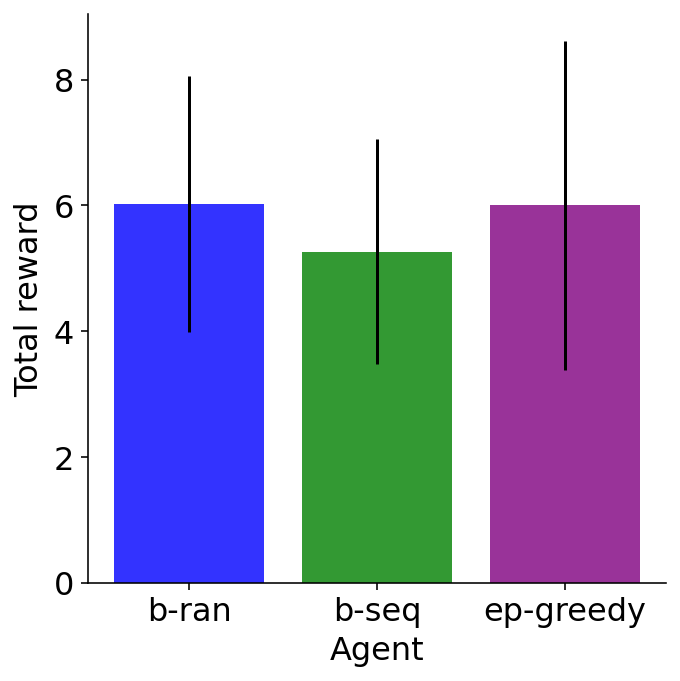

In [69]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 5))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Agent")
plt.tight_layout()
sns.despine()

In [70]:
num_steps = 100
num_experiments = 250

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

b-ran:   0%|          | 0/250 [00:00<?, ?it/s]

b-seq:   0%|          | 0/250 [00:00<?, ?it/s]

ep-greedy:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

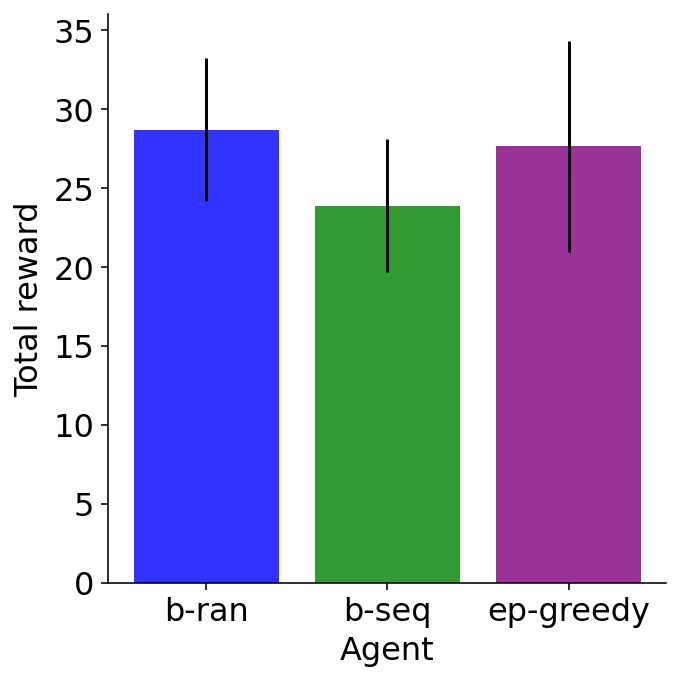

In [71]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 5))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Agent")
plt.tight_layout()
sns.despine()

In [72]:
num_steps = 1600
num_experiments = 250

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

b-ran:   0%|          | 0/250 [00:00<?, ?it/s]

b-seq:   0%|          | 0/250 [00:00<?, ?it/s]

ep-greedy:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

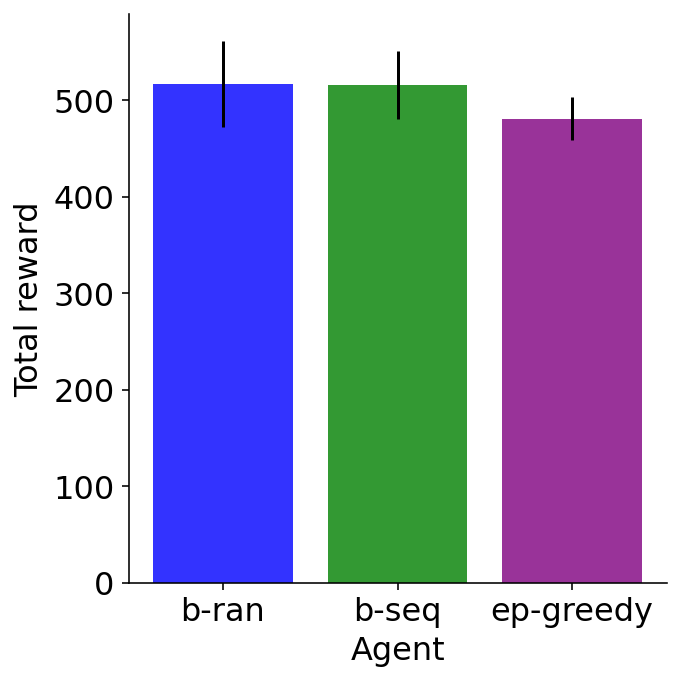

In [73]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 5))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Agent")
plt.tight_layout()
sns.despine()

### Question [5 pts]

Did the same agent always win? Or did different agents perform better at higher or lower step counts (compared to the baseline of 400 steps)?  Base your answer on your plots.

At the baseline of 400 steps, all of them performed similarly, though random barely beat out sequential which barely beat out greedy. In both sims below 400 steps, random and greedy outperformed sequential by a lot though were similiar to each other (essentially equal for 25, random slightly larger than greedy at 100). Above 400 steps, this difference in performance went away and the results pretty much mirror the 400 step findings, though at 1600, random and sequential are essentially equal and both slightly higher than greedy.